In [1]:
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

## Project Description

This Project looks at the top companies in the S&P 500 and attempts to predict it's price for the last month given data from 10 years ago (2012-present). The project is an attempt to use deep learning and neuiral entworks to achieve" high accuracies. The goal of this project is to be able to expand it to all market sectors. The data used for this project is pulled from the Yahoo Finance API, whereas the list of tickers for the S&P 500 is read directly fromm Wikipedia

## EDA

In [2]:
## Looking at Sample ticker data trends (Closing Price as Y variable)

In [3]:
techTickers = ["AAPL", 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
techNames = ['Apple', 'Microsoft', 'Google', 'Amazon', 'Tesla']
dataColumns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

In [4]:
data = yf.download("AAPL MSFT GOOGL AMZN TSLA", start="2012-01-01").fillna(method='ffill')

[*********************100%***********************]  5 of 5 completed


In [5]:
data.Close

,AAPL,AMZN,GOOGL,MSFT,TSLA
Date,,,,,
2012-01-03,14.686786,179.029999,333.038025,26.770000,5.616000
2012-01-04,14.765714,177.509995,334.474487,27.400000,5.542000
2012-01-05,14.929643,177.610001,329.834839,27.680000,5.424000
2012-01-06,15.085714,182.610001,325.335327,28.110001,5.382000
2012-01-09,15.061786,178.559998,311.541534,27.740000,5.450000
...,...,...,...,...,...
2022-05-19,137.350006,2146.379883,2207.679932,253.139999,709.419983
2022-05-20,137.589996,2151.820068,2178.159912,252.559998,663.900024
2022-05-23,143.110001,2151.139893,2229.760010,260.649994,674.900024


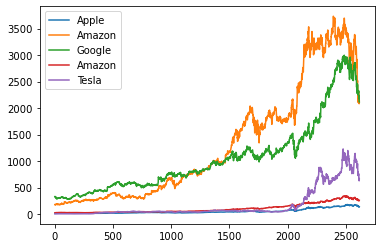

In [6]:
plt.plot(range(len(data)), data.Close.values, label = ["Apple", 'Amazon', 'Google', 'Amazon', 'Tesla'])
plt.legend(loc="upper left")

In [7]:
# When certain stocks are way out of scale compared to others, their apparent patterns can be hidden or compressed

[*********************100%***********************]  1 of 1 completed


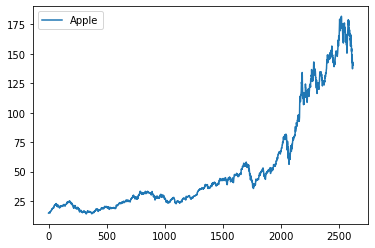

[*********************100%***********************]  1 of 1 completed


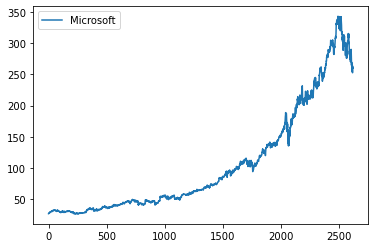

[*********************100%***********************]  1 of 1 completed


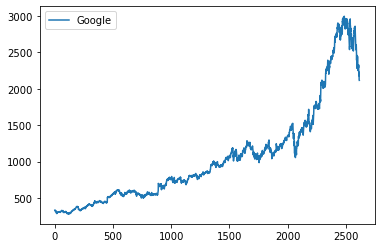

[*********************100%***********************]  1 of 1 completed


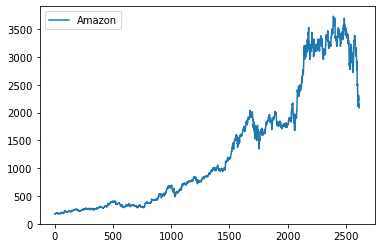

[*********************100%***********************]  1 of 1 completed


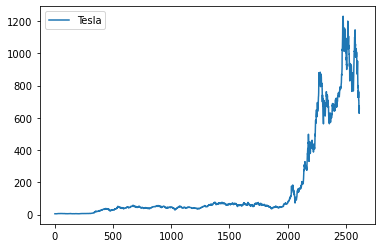

In [8]:
# In general, tech companies (Tech Giants follow a similar exponential pattern)

for n in range(len(techTickers)):
    data = yf.download(techTickers[n], start="2012-01-01").fillna(method='ffill')
    plt.plot(range(len(data)), data.Close.values, label = techNames[n])
    plt.legend(loc="upper left")
    plt.show()  

In [9]:
## Now, we want to expand to all companies listen in the S&P 500

In [10]:
sp500=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

In [11]:
tickers = sp500.Symbol.values
companyNames = sp500.Security

[*********************100%***********************]  504 of 504 completed

2 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


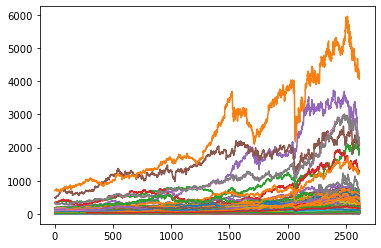

In [12]:
# As usual, the same problem withs caling can be seen, however, wen can see htat most if not all companies follow similar exponential patterns

data = yf.download(' '.join(tickers), start="2012-01-01")
plt.plot(range(len(data)), data.Close.values)
plt.show()  

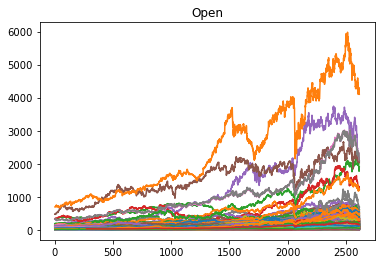

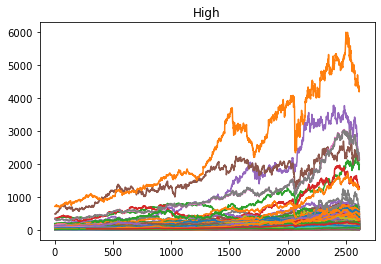

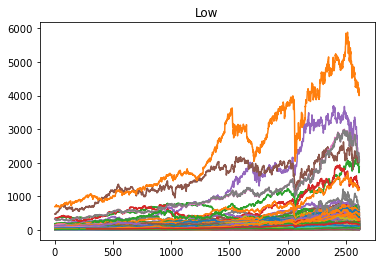

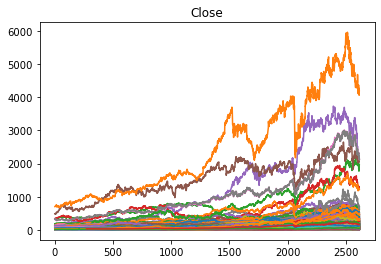

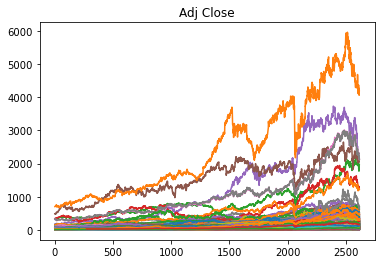

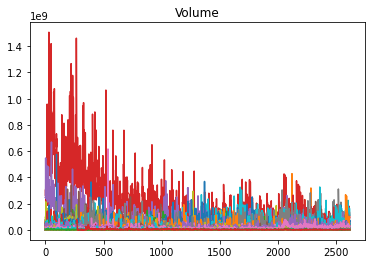

In [13]:
# Now that we know what the shape of closing prices look like, I was interested in looking at the shape of other variables

for n in dataColumns:
    
    plt.plot(range(len(data)), data[n].values)
    plt.title(n)
    plt.show()  

In [14]:
# Overall, all patterns seem to be pretty similar, except for volumne, which looked to be somewhat inverse of all other 
# patterns.

# Because of the scale that volume is measured in, I believe that it will not be a useful feature in predicting closing price

## Data Preping

In [15]:
# For training purposes, we will use 75 of the companies listed in the S&P 500 chosen at random

# Yahoo doesn't have data for tickers BRK.B and BF.B
sp500=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0].fillna(method='ffill')
sp500 = sp500[sp500['Symbol'] != 'BRK.B']
sp500 = sp500[sp500['Symbol'] != 'BF.B']


tickers = sp500.Symbol.values
companyNames = sp500.Security

In [16]:
data = yf.download(' '.join(tickers), start="2012-01-01")

[*********************100%***********************]  502 of 502 completed


In [17]:
# Setting numpy random seed
np.random.seed(0)

trainAmount = int(round(len(tickers)*0.75, 0))
trainTickerIndexes = np.random.choice(np.arange(len(tickers)), trainAmount, replace=False)


trainTickers = tickers[trainTickerIndexes]
testTickers = np.delete(tickers,trainTickerIndexes)

In [20]:
# All columns of full dataset

closeData = data.Close.fillna(data.Close.mean().mean())
# volData = data.Volume.fillna(0)
openData = data.Open.fillna(data.Open.mean().mean())
highData = data.High.fillna(data.High.mean().mean())
lowData = data.Low.fillna(data.Low.mean().mean())

In [21]:
# Seperating into train and testing sets and creating torch tensors

closeDataTrain = torch.tensor(closeData[trainTickers].values.T, requires_grad=True).unsqueeze(2)
closeDataTest = torch.tensor(closeData[testTickers].values.T, requires_grad=True).unsqueeze(2)

# volDataTrain = torch.tensor(volData[trainTickers].values.T, requires_grad=True).unsqueeze(2)
# volDataTest = torch.tensor(volData[testTickers].values.T, requires_grad=True).unsqueeze(2)

openDataTrain = torch.tensor(openData[trainTickers].values.T, requires_grad=True).unsqueeze(2)
openDataTest = torch.tensor(openData[testTickers].values.T, requires_grad=True).unsqueeze(2)

highDataTrain = torch.tensor(highData[trainTickers].values.T, requires_grad=True).unsqueeze(2)
highDataTest = torch.tensor(highData[testTickers].values.T, requires_grad=True).unsqueeze(2)

lowDataTrain = torch.tensor(lowData[trainTickers].values.T, requires_grad=True).unsqueeze(2)
lowDataTest = torch.tensor(lowData[testTickers].values.T, requires_grad=True).unsqueeze(2)


In [22]:
# Define the prediction time period (X and Y seperation period)

timePeriodToPredict = 365

In [23]:
trainY = closeDataTrain[:,-timePeriodToPredict:, :] # Getting data from only last month

closeDataTrainX = closeDataTrain[:,:-timePeriodToPredict, :]
# volDataTrainX = volDataTrain[:,:-timePeriodToPredict, :]
openDataTrainX = openDataTrain[:,:-timePeriodToPredict, :]
highDataTrainX = highDataTrain[:,:-timePeriodToPredict, :]
lowDataTrainX = lowDataTrain[:,:-timePeriodToPredict, :]

In [24]:
testY = closeDataTest[:,-timePeriodToPredict:, :] # Getting data from only last month

closeDataTestX = closeDataTest[:,:-timePeriodToPredict, :]
# volDataTestX = volDataTest[:,:-timePeriodToPredict, :]
openDataTestX = openDataTest[:,:-timePeriodToPredict, :]
highDataTestX = highDataTest[:,:-timePeriodToPredict, :]
lowDataTestX = lowDataTest[:,:-timePeriodToPredict, :]

In [25]:
# Concating all data into one tensor for both trian and test

# trainX = torch.cat((closeDataTrainX, volDataTrainX), 2)
trainX = torch.cat((closeDataTrainX, openDataTrainX), 2)
trainX = torch.cat((trainX, highDataTrainX), 2)
trainX = torch.cat((trainX, lowDataTrainX), 2)

# testX = torch.cat((closeDataTestX, volDataTestX), 2)
testX = torch.cat((closeDataTestX, openDataTestX), 2)
testX = torch.cat((testX, highDataTestX), 2)
testX = torch.cat((testX, lowDataTestX), 2)

In [26]:
trainX.shape

torch.Size([376, 2257, 4])

In [27]:
trainY.shape

torch.Size([376, 365, 1])

## Model building

### LSTM w/ FC Model Building

In [47]:
output_dim = 1
feature_size = 4
hidden_size = 256
num_layers = 1
lr = 0.001
epochs = 50
batch_size = 8

In [48]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [49]:
class LSTM(nn.Module):
    def __init__(self, feature_size, hidden_size, output_dim, num_layers = 1):
        super(LSTM, self).__init__()
        
        self.feature_size = feature_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_dim = output_dim
        
        self.lstm = nn.LSTM(self.feature_size, self.hidden_size, batch_first = True).to(device)
        
        self.fc1 = nn.Linear(self.hidden_size, self.hidden_size).to(device)
        self.fc2 = nn.Linear(self.hidden_size, self.output_dim).to(device)
        
    def forward(self, x):
        
        h_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size, requires_grad = True).to(device)
        c_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size, requires_grad = True).to(device)
        
        lstmOut, _ = self.lstm(x, (h_0, c_0))
        
        lstmOut = lstmOut[:,-timePeriodToPredict:, :]
        
        fc1 = self.fc1(lstmOut)
        fc2 = self.fc2(fc1)
        
        return fc2

In [50]:
lstm = LSTM(feature_size, hidden_size, output_dim, num_layers).to(device)

optimizer = optim.Adam(lstm.parameters(), lr = lr)

lossFunction = nn.MSELoss().to(device)

### LSTM Model Training

In [51]:
#Input normalization

mean = trainX.mean()
std = trainX.std()
temp = torch.sub(trainX, mean)
trainXNormalized = torch.div(temp, std)

In [ ]:
trainLoss = []

for i in tqdm(range(epochs)):
    for n in range(batch_size, trainX.shape[0], batch_size):
        lstm.zero_grad()
        inp = trainX[n-batch_size:n, :, :].to(torch.float32)
        out = trainY[n-batch_size:n, :, :].to(torch.float32)
        
        output = lstm(inp)
        
        loss = lossFunction(output, out)
        trainLoss.append(loss)
        loss.backward()
        optimizer.step()
        

 78%|███████▊  | 39/50 [2:06:23<47:44, 260.45s/it]  

In [ ]:
trainLoss = [int(x) for x in trainLoss]

In [ ]:
plt.plot(range(len(trainLoss)), trainLoss)
plt.title('Training Loss')
plt.show()

### LSTM Testing

In [ ]:
testLosses = []

for n in tqdm(range(batch_size, testX.shape[0], batch_size)):
    inp = testX[n-batch_size:n, :, :].to(torch.float32)
    out = testY[n-batch_size:n, :, :].to(torch.float32)

    output = lstm(inp)

    loss = lossFunction(output, out)
    testLosses.append(loss)

In [ ]:
testLosses = [int(x) for x in testLosses]
plt.plot(range(len(testLosses)), testLosses)
plt.title('Test Loss')
plt.show()

In [ ]:
## Graphing out sample batch inputs and outputs
inpClosingPrices = inp[:,:,0].detach().numpy() # revertinng tensors back into numpy arrays
outClosingPrices = output[:,:,0].detach().numpy()
outputReal = out[:,:,0].detach().numpy()

totalEntries = int(outClosingPrices.shape[1]) + int(inpClosingPrices.shape[1])

In [ ]:
 for i in range(batch_size):
    plt.plot(range(int(inpClosingPrices.shape[1])), inpClosingPrices[i,:], label = 'Input') # Plotting inputs
    plt.plot(range(totalEntries-timePeriodToPredict, totalEntries), outClosingPrices[i,:], label = 'Model Output') # Plotting outputs
    plt.plot(range(totalEntries-timePeriodToPredict, totalEntries), outputReal[i,:], label = 'Actual Output') # Plotting Actual outputs
    plt.legend(loc="upper left")
    plt.show()